In [ ]:
# !python -m spacy download da_core_news_sm

In [1]:
import spacy
import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from spacy import displacy
from collections import Counter

In [2]:
nlp = spacy.load("da_core_news_lg")

In [3]:
# with open(path, encoding = "utf8") as f: 
#      txt = f.read() 

In [4]:

# path = os.path.join("..", "1_Tæl_din_tekst", "Data", "Statsministerens_nytårstale", "2019_LL.txt")


textt = nlp("Mette kysser Jakob")
xxx = [child.pos_ for child in textt[1].children]
print(xxx)
"AUX" not in xxx

### Teksteksempel

In [5]:
txt = nlp("Mette, der er 24 år, læser på AU. Hun bor i Aarhus. Aarhus, som har mange uddannelsesinstitutioner, har mange studerende. Fordi hun studerer, bor hun på kollegium. Hun skal heldigvis have ferie, når hun har været til eksamen. Efter ferien skal hun tilbage på universitetet. Hvis hun er holder planen, er hun færdig om to år. På mandag skal hun til tandlægen. Bagefter skal hun hjem og se netflix. På tirsdag skal hun blive hjemme. Det skal hun også på onsdag.")

# Forfelt som string + gennemsnitslængde

In [6]:
### denne funktion returnerer en liste med forfeltet for sætning som string
def forfelt_string(nlpobject):
    forfeltStr = [] # liste med forfeltet som string for hver sætning i teksten
    for id, s in enumerate(nlpobject.sents):# enumerate() giver hver sætning et id-nummer
        vid = [] #liste til verbernes id-nummer
        for i,w in enumerate(s):#denne sekvens identificerer de finitte verbums id-nummer for hver sætning
            if w.dep_== "aux" and w.head.dep_ == "ROOT": #hvis V1 = hjælpeverbum
                vid.append(i)
            elif w.pos_ == "VERB" and w.dep_ == "ROOT" and "aux" not in [child.dep_ for child in w.children]: #hvis V1 er hovedverbet
                vid.append(i)
            elif w.pos_== "AUX" and w.dep_ == "cop" and w.head.dep_ != "acl:relcl": #sorterer relativ ledsætninger med 'er' fra
                vid.append(i)
            elif w.pos_== "AUX" and w.head.pos_ == "ADV": #usikker - eks: "bagefter skal hun hjem"
                vid.append(i)
            elif w.pos_== "AUX" and w.head.dep_ == "ROOT": # inkluderer tilfælde, hvor 'skal' ikke ikke følges af hovedverbum og derfor er root
                vid.append(i)
        forfelt = [] # laver en liste for hver sætning med de nlpObjekt-tokens, der hører til forfeltet
        for i,w in enumerate(s):
            if len(vid) > 0:# hvis(for hver sætning) listen  med verbernes id ikke e tom
                fvi = vid[0] #så er det finitte verbums id-nummer, det første id-nummer på listen
                if i < fvi:# hvis et ords id-nummer er lavere end det finitte verbums id-nummer
                    forfelt.append(w) # så tilføjes dette nlpObject-token til listen
        forfelt_ord = []
        for w in forfelt:
            forfelt_ord.append(w.text)
        lst = " ".join(forfelt_ord)
        forfeltStr.append(lst) 
    return(forfeltStr)

In [7]:
### Denne funktion returnerer det gennemsnitlige antal ord for en teksts forfelter
def meanLenForf(nlpobject):
    strings = forfelt_string(nlpobject)
    stringsClean = [s.replace(",", " ") for s in strings]
    lenForf = [len(s.split()) for s in stringsClean]
    gennemsnit = sum(lenForf) / len(lenForf)
    return(gennemsnit)
    

### Eksempler

In [8]:
forfelt_string(txt)

['Mette , der er 24 år ,',
 'Hun',
 'Aarhus , som har mange uddannelsesinstitutioner ,',
 'Fordi hun studerer ,',
 'Hun',
 'Efter ferien',
 'Hvis hun er holder planen ,',
 'På mandag',
 'Bagefter',
 'På tirsdag',
 'Det']

In [9]:
test = meanLenForf(txt)
print(test)

2.5454545454545454


# Forfelt som Spacy-tags + ordklasseratio for felterne i en tekst

In [10]:
### Denne function returnerer en liste med lister af spacy-tokens for hvert forfelt i en tekst
def forfelt_tokNLP(nlpobject):
    forfelt_info = []
    for id, s in enumerate(nlpobject.sents):# enumerate() giver hver sætning et id-nummer
        vid = [] #liste til verbernes id-nummer
        for i,w in enumerate(s):#denne sekvens identificerer de finitte verbums id-nummer for hver sætning
            if w.dep_== "aux" and w.head.dep_ == "ROOT": #hvis V1 = hjælpeverbum
                vid.append(i)
            elif w.pos_ == "VERB" and w.dep_ == "ROOT" and "aux" not in [child.dep_ for child in w.children]: #hvis V1 er hovedverbet
                vid.append(i)
            elif w.pos_== "AUX" and w.dep_ == "cop" and w.head.dep_ != "acl:relcl": #sorterer relativ ledsætninger med 'er' fra
                vid.append(i)
            elif w.pos_== "AUX" and w.head.pos_ == "ADV": #usikker - eks: "bagefter skal hun hjem"
                vid.append(i)
            elif w.pos_== "AUX" and w.head.dep_ == "ROOT": # inkluderer tilfælde, hvor 'skal' ikke ikke følges af hovedverbum og derfor er root
                vid.append(i)
        forfelt = [] # laver en liste for hver sætning med de nlpObjekt-tokens, der hører til forfeltet
        for i,w in enumerate(s):
            if len(vid) > 0:# hvis(for hver sætning) listen  med verbernes id ikke e tom
                fvi = vid[0] #så er det finitte verbums id-nummer, det første id-nummer på listen
                if i < fvi:# hvis et ords id-nummer er lavere end det finitte verbums id-nummer
                    forfelt.append(w) # så tilføjes dette nlpObject-token til listen
        forfelt_info.append(forfelt) 
    return(forfelt_info)

In [11]:
### denne funktion returnerer en dictionary med en optaælling af det samlede antal POS-tags i en teksts forfelter
def freqPosForf(nlpobject):
    forfRaw = forfelt_tokNLP(txt) #returnerer en liste med lister af spacy-tokens for hvert forfelt i en tekst
    txtPosTags = [] # følgende sekvens danner en liste med det samlede antal POS-tags for tekstens forfelter
    for f in forfRaw:
        for t in f:
            if t.pos_ != "PUNCT":
                txtPosTags.append(t.pos_)
    counter = {}
    for tag in txtPosTags:
        if tag not in counter:
            counter[tag] = 0
        counter[tag] += 1
    return(counter)

In [12]:
forfelt_tokNLP(txt)

[[Mette, ,, der, er, 24, år, ,],
 [Hun],
 [Aarhus, ,, som, har, mange, uddannelsesinstitutioner, ,],
 [Fordi, hun, studerer, ,],
 [Hun],
 [Efter, ferien],
 [Hvis, hun, er, holder, planen, ,],
 [På, mandag],
 [Bagefter],
 [På, tirsdag],
 [Det]]

In [13]:
freqPosForf(txt)

{'PROPN': 2,
 'ADV': 2,
 'AUX': 2,
 'NUM': 1,
 'NOUN': 6,
 'PRON': 6,
 'VERB': 3,
 'ADJ': 1,
 'SCONJ': 2,
 'ADP': 3}

# Pie chats POS

In [14]:
import matplotlib.pyplot as plt

In [15]:
posDict = freqPosForf(txt)
posDict

{'PROPN': 2,
 'ADV': 2,
 'AUX': 2,
 'NUM': 1,
 'NOUN': 6,
 'PRON': 6,
 'VERB': 3,
 'ADJ': 1,
 'SCONJ': 2,
 'ADP': 3}

In [16]:
posDict_2 = {'PROPN': 2,
 'ADV': 2,
 'AUX': 2,
 'NUM': 1,
 'NOUN': 6,
 'PRON': 6,
 'VERB': 3,
 'ADJ': 1,
 'SCONJ': 2,
 'ADP': 3}

# Merger dictionaries, så de kan plottes

In [17]:
d_1 = Counter(posDict)
d_2 = Counter(posDict_2)
posDict_3 = dict(d_1 + d_2) # gør counteren til en dictionary, så den kan plottes

In [18]:
posDict_3

{'PROPN': 4,
 'ADV': 4,
 'AUX': 4,
 'NUM': 2,
 'NOUN': 12,
 'PRON': 12,
 'VERB': 6,
 'ADJ': 2,
 'SCONJ': 4,
 'ADP': 6}

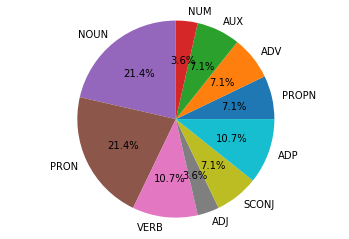

In [19]:
import matplotlib.pyplot as plt
your_data = {
    'PROPN': 2,
    'ADV': 2,
    'AUX': 2,
    'NUM': 1,
    'NOUN': 6,
    'PRON': 6,
    'VERB': 3,
    'ADJ': 1,
    'SCONJ': 2,
    'ADP': 3}


# Data to plot
labels = []
sizes = []

for x, y in your_data.items():
    labels.append(x)
    sizes.append(y)

# Plot
plt.pie(sizes, labels = labels, autopct='%1.1f%%')

plt.axis('equal')
plt.show()

# Dependency trees

In [20]:
sentence_spans = list(txt.sents)

In [21]:
displacy.render(sentence_spans, style="dep")